In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Combining

In [226]:
sheet1 = pd.read_csv('./survey_responses.csv')
sheet2 = pd.read_csv('./survey_responses_2_corrected.csv')

In [227]:
cols1 = sheet1.columns
cols2 = sheet2.columns
print(f'Columns in 1: {len(cols1)}, Columns in 2: {len(cols2)}')
print(f'Columns not shared: {(set(cols1) - set(cols2)) | (set(cols2) - set(cols1))}')

Columns in 1: 27, Columns in 2: 26
Columns not shared: {'What is your age?'}


In [228]:
df = pd.concat([sheet1,sheet2], axis=0).reset_index(drop=True)
df = df.drop(columns=['Timestamp'])
df = df.rename(columns={
    'Which gender identity best describes you?': 'gender',
    'What configuration of the system did you interact with? Ask the assisting student if unsure.' : 'version',
    'What is your age?': 'age'
})
df['version'] = df['version'].map(lambda s: s.replace('Version ',''))
df['Memory'] = df['version'].map({
    'A': 'Short-term only',
    'B': 'Complete memory',
})
df.head()

,The system is accurate,The system is unreliable,The interaction with the system is unpredictable,The system didn't always do what I wanted,The system didn't always do what I expected,The system is dependable,The system makes few errors,The interaction with the system is consistent,The interaction with the system is efficient,The system is useful,...,I felt in control of the interaction with the system,The interaction with the system is repetitive,The interaction with the system is boring,The interaction with the system is irritating,The interaction with the system is frustrating,The system is too inflexible,age,gender,version,Memory
0,5,4,3,2,5,2,5,7,3,6,...,6,7,2,2,3,3.0,23.0,Man,B,Complete memory
1,3,5,3,5,5,5,3,5,5,5,...,5,2,3,3,3,2.0,23.0,Man,A,Short-term only
2,6,1,1,1,2,6,7,7,6,7,...,6,1,2,1,1,3.0,24.0,Woman,B,Complete memory
3,3,6,2,3,3,4,2,3,2,5,...,6,5,5,5,2,5.0,23.0,Man,A,Short-term only
4,5,2,2,5,3,5,6,7,2,5,...,5,3,5,5,7,2.0,22.0,Man,B,Complete memory


# Demographics

In [229]:
print(f'Number of participants: {len(df)}')
print(f'Women: {(df['gender']=='Woman').sum()}, Men: {(df['gender']=='Man').sum()}')
print(f'Age: {df['age'].mean():.2f} ± {df['age'].std():.2f}')

Number of participants: 30
Women: 10, Men: 20
Age: 22.86 ± 1.56


# Compute Factors

In [230]:
factors = pd.read_csv('./factors.csv')
factors = factors.set_index('Component',drop=True)
factors = factors.rename(columns={
    '1': 'System Response Accuracy',
    '2': 'Likeability',
    '3': 'Cognitive Demand',
    '4': 'Annoyance',
    '5': 'Habitability',
    '6': 'Speed',
})
# factors = factors.fillna(0)
factors.head()

,System Response Accuracy,Likeability,Cognitive Demand,Annoyance,Habitability,Speed
Component,,,,,,
The system is accurate,0.799,NaN,NaN,NaN,NaN,NaN
The system is unreliable,-0.736,NaN,NaN,NaN,NaN,NaN
The interaction with the system is unpredictable,-0.719,NaN,NaN,NaN,NaN,NaN
The system didn't always do what I wanted,-0.718,NaN,NaN,NaN,NaN,NaN
The system didn't always do what I expected,-0.713,NaN,NaN,NaN,NaN,NaN


In [231]:
print(f'--- Available survey components for each factor ---')
for f in factors.columns:
    relevant_components = factors[~factors[f].isna()].index
    matches = [col for col in df.columns if col in relevant_components]
    print(f'{f}: {len(matches)}/{len(relevant_components)}')

--- Available survey components for each factor ---
System Response Accuracy: 9/9
Likeability: 9/9
Cognitive Demand: 0/5
Annoyance: 5/5
Habitability: 0/4
Speed: 0/2


In [232]:
our_factors = ['System Response Accuracy', 'Likeability', 'Annoyance']
for f in our_factors:
    loadings = factors[f].dropna()
    components = loadings.index
    responses = df[components]
    n = len(components)

    # This normalisation step isn't necessary, it just makes the result be nicely in the range [-1,+1]
    # Feel free to comment out
    loadings /= np.linalg.norm(loadings) # make factor loadings a unit vector
    responses = (responses - 4) / 3  # normalize likert scale responses to [-1, +1]
    responses = responses / np.sqrt(n) # normalize the response vector to be at most length 1, if all values were at their extremes

    # Compute the results with dot product between response and factor loadings for this factor
    df[f] = responses.dot(loadings)
df.head()

,The system is accurate,The system is unreliable,The interaction with the system is unpredictable,The system didn't always do what I wanted,The system didn't always do what I expected,The system is dependable,The system makes few errors,The interaction with the system is consistent,The interaction with the system is efficient,The system is useful,...,The interaction with the system is irritating,The interaction with the system is frustrating,The system is too inflexible,age,gender,version,Memory,System Response Accuracy,Likeability,Annoyance
0,5,4,3,2,5,2,5,7,3,6,...,2,3,3.0,23.0,Man,B,Complete memory,0.144067,0.484768,-0.133101
1,3,5,3,5,5,5,3,5,5,5,...,3,3,2.0,23.0,Man,A,Short-term only,-0.056485,0.184827,-0.457749
2,6,1,1,1,2,6,7,7,6,7,...,1,1,3.0,24.0,Woman,B,Complete memory,0.846748,0.929593,-0.810847
3,3,6,2,3,3,4,2,3,2,5,...,5,2,5.0,23.0,Man,A,Short-term only,-0.133133,0.409472,0.158574
4,5,2,2,5,3,5,6,7,2,5,...,5,7,2.0,22.0,Man,B,Complete memory,0.338486,0.479992,0.130344


# Compare

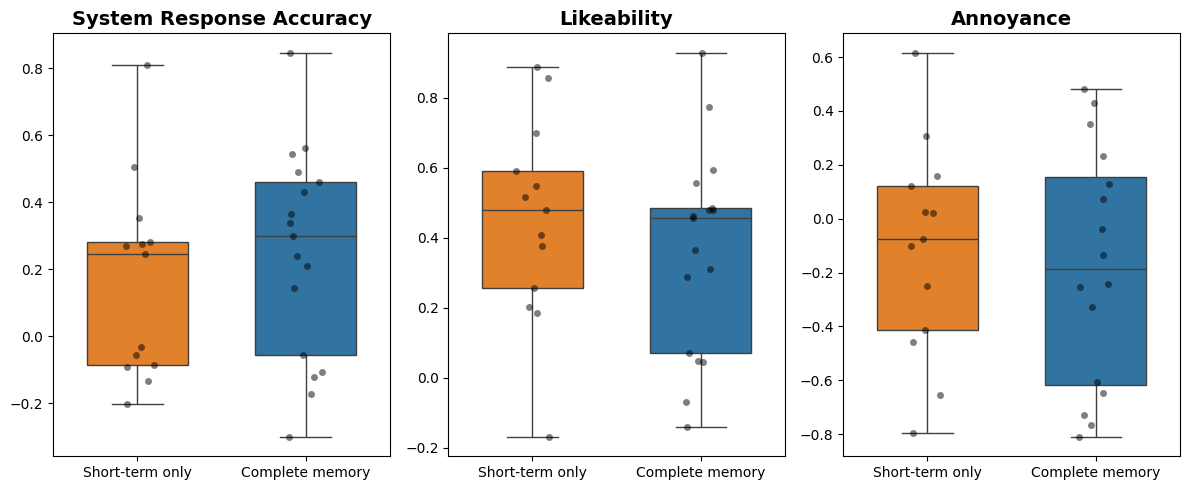

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

#  Create a figure with appropriate size
plt.figure(figsize=(12, 5))

# Create a boxplot for each factor, comparing versions A and B
for i, factor in enumerate(our_factors, 1):
    plt.subplot(1, 3, i)
    
    # Create the boxplot
    sns.boxplot(
        x="Memory", 
        y=factor, 
        data=df, 
        width=0.6,
        hue="Memory",  # Use Memory as hue parameter instead of palette
        legend=False,   # Hide the legend since it's redundant
        order=['Short-term only', 'Complete memory']
    )
    # Add individual data points for better visualization
    sns.stripplot(
        x="Memory", 
        y=factor, 
        data=df, 
        color="black", 
        alpha=0.5, 
        jitter=True,
        size=5,
    )
    
    # Customize the plot
    plt.title(f"{factor}", fontsize=14, fontweight='bold')
    plt.xlabel("")
    plt.ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()


In [234]:
import scipy.stats as stats

# Perform t-tests for each factor comparing the two memory conditions
print("T-test results comparing 'Short-term only' vs 'Complete memory':")
print("-" * 60)

num_sig = 0
for factor in our_factors:

    # Get data for each group
    short_term_data = df[df['Memory'] == 'Short-term only'][factor].dropna()
    complete_memory_data = df[df['Memory'] == 'Complete memory'][factor].dropna()

    
    # Perform two-sided independent t-test (non-paired)
    t_stat, p_value = stats.ttest_ind(short_term_data, complete_memory_data, equal_var=False)
    
    # Print results
    print(f"{factor}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    # Indicate significance
    if p_value < 0.01:
        print("  ** Significant difference (p < 0.01)")
        num_sig+=1
    elif p_value < 0.05:
        print("  * Significant difference (p < 0.05)")
        num_sig+=1
    print()

print(f'Number of significant results: {num_sig}')


T-test results comparing 'Short-term only' vs 'Complete memory':
------------------------------------------------------------
System Response Accuracy:
  t-statistic: -0.7265
  p-value: 0.4739

Likeability:
  t-statistic: 0.8185
  p-value: 0.4205

Annoyance:
  t-statistic: 0.4081
  p-value: 0.6864

Number of significant results: 0
